In [ ]:
import polars as pl;
import csv;

Carga de datos desde Drive

In [ ]:

from google.colab import drive, files # type: ignore

drive.mount('/content/drive')
log_file_path = '/content/drive/My Drive/Colab_Folder/access.log'
csv_file_path = '/content/drive/My Drive/Colab_Folder/archivo.csv'

Mounted at /content/drive


Carga de datos desde Kaggle

In [ ]:
from google.colab import userdata # type: ignore
import os
%pip install -U -q kaggle 

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!mkdir -p ~/.kaggle
!kaggle datasets download -d sofiamartinez222324/infraestructura-de-datos-espaciales-uy
!unzip infraestructura-de-datos-espaciales-uy.zip

SecretNotFoundError: Secret KAGGLE_USERNAME does not exist.

Convertir archivos .logs a .csv para poder trabajar con Polars

In [ ]:
# Abro el archivo original .log
with open(log_file_path, 'r') as file:
    log_data = file.readlines()

# Los encabezados para el archivo .csv
headers = ["ip", "timestamp", "request_method", "url", "http_version", "status_code", "size", "user_agent"]

# Lo leo linea por linea y voy guardando la info en el archivo.csv
with open(csv_file_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(headers)

    for line in log_data:
        parts = line.split(' ')

        try:
            ip = parts[0]
            timestamp = ' '.join(parts[3:5]).strip('[]')
            request_method = parts[5].strip('"') if parts[5] != '"-"' else None
            url = parts[6] if len(parts) > 6 else None
            http_version = parts[7].strip('"') if len(parts) > 7 else None
            status_code = int(parts[8]) if len(parts) > 8 and parts[8].isdigit() else None
            size = int(parts[9]) if len(parts) > 9 and parts[9].isdigit() else None
            user_agent = ' '.join(parts[11:]).strip('"') if len(parts) > 11 else None

            csvwriter.writerow([ip, timestamp, request_method, url, http_version, status_code, size, user_agent])

        except (IndexError, ValueError) as e:
            print(f"Error procesando la línea: {line.strip()} - Error: {e}")
            csvwriter.writerow([ip, timestamp, None, None, None, None, None, None])

## Funciones Auxiliares

#### **filtrar_map_server:**
MapServer es una plataforma de código abierto para publicar datos espaciales y aplicaciones interactivas de mapeo en la web.
libcurl es una biblioteca utilizada por MapServer para manejar transferencias de datos a través de varios protocolos de red.

---

#### **filtar_wms:**
Un WMS (Web Map Service) es un estándar desarrollado por el OGC (Open Geospatial Consortium) que permite la visualización de mapas georreferenciados a través de la web. Un servicio WMS puede devolver imágenes de mapas basadas en datos geográficos, y el documento de capacidades describe cómo se pueden solicitar estas imágenes y qué capas están disponibles.

Dado que todas las solicitudes son muy cercanas en tiempo y provienen de la misma ip, se podría decir que: Un usuario hizo varias solicitudes consecutivas rápidamente. O, lo que es más probable, un script o un programa hizo esas solicitudes.

---

#### **filtrar_jcemediabox:**
Estas URLs están asociadas con JCEMediaBox, un plugin de Joomla que facilita la incorporación de lightboxes para mostrar imágenes, vídeos y otros tipos de medios de una manera atractiva y funcional. Los archivos .js contienen el código JavaScript necesario para hacer funcionar el lightbox, mientras que los archivos .css contienen los estilos que determinan la apariencia del lightbox en la página web.

---

#### **filtrar_css y filtrar_js:**
El objetivo de nuestro análisis es entender el tráfico relacionado con la funcionalidad del sitio y excluir contenido estático como .css y .js. Por lo que decidimos filtrar estos archivos. Si quisiéramos hacer un análisis más completo del tráfico, deberíamos mantener estos archivos.

Pero los archivos .css y .js son muy frecuentes en los logs y filtrarlos puede reducir el "ruido" en los datos, permitiéndonos enfocarnos en las solicitudes más relevantes.


In [ ]:
##### Funciones auxiliares - Limpieza de datos
def obtener_total_registros():
    return df.height # type: ignore

def contar_registros_url(df, regex):
    return df.filter(pl.col("url").str.contains(regex)).height

def contar_registros_user_agent(df, regex):
    return df.filter(pl.col("user_agent").str.contains(regex)).height

# Robos y Crawlers
def contar_filtros_robots(df):
    total_registros = obtener_total_registros()

    registros_googlebot = contar_registros_user_agent(df, 'Googlebot')
    registros_baiduspider = contar_registros_user_agent(df, 'Baiduspider')
    registros_agesic_crawler = contar_registros_user_agent(df, 'agesic-crawler')

    porcentaje_googlebot = (registros_googlebot / total_registros) * 100
    porcentaje_baiduspider = (registros_baiduspider / total_registros) * 100
    porcentaje_agesic_crawler = (registros_agesic_crawler / total_registros) * 100

    print(f"Registros 'Googlebot': {registros_googlebot} ({porcentaje_googlebot:.2f}%)")
    print(f"Registros 'Baiduspider': {registros_baiduspider} ({porcentaje_baiduspider:.2f}%)")
    print(f"Registros 'agesic-crawler': {registros_agesic_crawler} ({porcentaje_agesic_crawler:.2f}%)")

def filtrar_googlebot(df):
    return df.filter(~pl.col("user_agent").str.contains('Googlebot'))

def filtrar_baiduspider(df):
    return df.filter(~pl.col("user_agent").str.contains('Baiduspider'))

def filtrar_agesic_crawler(df):
    return df.filter(~pl.col("user_agent").str.contains('agesic-crawler'))

def filtrar_robots_y_crawlers(df):
    contar_filtros_robots(df)
    df = filtrar_googlebot(df)
    df = filtrar_baiduspider(df)
    df = filtrar_agesic_crawler(df)
    return df

# Servicios de mapas
def contar_filtros_servicios_mapas(df):
    total_registros = obtener_total_registros()

    registros_map_server = contar_registros_url(df, '/wfsPCN1000.cgi')
    registros_wms = contar_registros_url(df, 'SERVICE=WMS')

    porcentaje_map_server = (registros_map_server / total_registros) * 100 if total_registros > 0 else 0
    porcentaje_wms = (registros_wms / total_registros) * 100 if total_registros > 0 else 0

    print(f"Registros '/wfsPCN1000.cgi': {registros_map_server} ({porcentaje_map_server:.2f}%)")
    print(f"Registros 'SERVICE=WMS': {registros_wms} ({porcentaje_wms:.2f}%)")

def filtrar_map_server(df):
    return df.filter(~pl.col("url").str.contains('/wfsPCN1000.cgi'))

def filtrar_wms(df):
    return df.filter(~pl.col("url").str.contains('SERVICE=WMS'))

def filtrar_solicitudes_servicios_mapas(df):
    contar_filtros_servicios_mapas(df)
    df = filtrar_map_server(df)
    df = filtrar_wms(df)
    return df

# Archivos estáticos
def contar_filtros_archivos_estaticos(df):
    total_registros = obtener_total_registros()

    registros_jcemediabox = contar_registros_url(df, '/plugins/system/jcemediabox/')
    registros_css = contar_registros_url(df, r'\.css$')
    registros_js = contar_registros_url(df, r'\.js$')
    registros_png = contar_registros_url(df, r'\.png$')
    registros_jpg = contar_registros_url(df, r'\.jpg$')
    registros_gif = contar_registros_url(df, r'\.gif$')
    registros_favicon = contar_registros_url(df, r'favicon\.ico$')

    porcentaje_jcemediabox = (registros_jcemediabox / total_registros) * 100
    porcentaje_css = (registros_css / total_registros) * 100
    porcentaje_js = (registros_js / total_registros) * 100
    porcentaje_png = (registros_png / total_registros) * 100
    porcentaje_jpg = (registros_jpg / total_registros) * 100
    porcentaje_gif = (registros_gif / total_registros) * 100
    porcentaje_favicon = (registros_favicon / total_registros) * 100

    print(f"Registros 'jcemediabox': {registros_jcemediabox} ({porcentaje_jcemediabox:.2f}%)")
    print(f"Registros '.css': {registros_css} ({porcentaje_css:.2f}%)")
    print(f"Registros '.js': {registros_js} ({porcentaje_js:.2f}%)")
    print(f"Registros '.png': {registros_png} ({porcentaje_png:.2f}%)")
    print(f"Registros '.jpg': {registros_jpg} ({porcentaje_jpg:.2f}%)")
    print(f"Registros '.gif': {registros_gif} ({porcentaje_gif:.2f}%)")
    print(f"Registros 'favicon.ico': {registros_favicon} ({porcentaje_favicon:.2f}%)")

def filtar_jcemediabox(df):
    return df.filter(~pl.col("url").str.contains('/plugins/system/jcemediabox/'))

def filtrar_css(df):
    regex = r'\.css$'
    return df.filter(~pl.col("url").str.contains(regex))

def filtrar_js(df):
    regex = r'\.js$'
    return df.filter(~pl.col("url").str.contains(regex))

def filtrar_png(df):
    regex = r'\.png$'
    return df.filter(~pl.col("url").str.contains(regex))

def filtrar_jpg(df):
    regex = r'\.jpg$'
    return df.filter(~pl.col("url").str.contains(regex))

def filtrar_gif(df):
    regex = r'\.gif$'
    return df.filter(~pl.col("url").str.contains(r'\.gif$'))

def filtrar_favicon(df):
    regex = r'favicon\.ico$'
    return df.filter(~pl.col("url").str.contains(r'favicon\.ico$'))

def filtrar_datos(df):
    contar_filtros_archivos_estaticos(df)
    df = filtar_jcemediabox(df)
    df = filtrar_css(df)
    df = filtrar_js(df)
    df = filtrar_png(df)
    df = filtrar_jpg(df)
    df = filtrar_gif(df)
    df = filtrar_favicon(df)
    return df

def formatear_fecha(df):
    return df.with_columns([pl.col("timestamp").str.strptime(pl.Datetime, "%d/%b/%Y:%H:%M:%S %z", strict=False).dt.strftime("%d-%m-%Y %H:%M:%S").alias("timestamp")])

## Main

In [ ]:
df = pl.read_csv(csv_file_path)

#### Reconocimiento del data frame
Veamos cómo está compuesto el dataframe

In [ ]:
df.schema

OrderedDict([('ip', Utf8),
             ('timestamp', Utf8),
             ('request_method', Utf8),
             ('url', Utf8),
             ('http_version', Utf8),
             ('status_code', Int64),
             ('size', Int64),
             ('user_agent', Utf8)])

Mostramos las primeras 5 filas del dataframe

In [ ]:
df.head(5)

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
str,str,str,str,str,i64,i64,str
"""127.0.0.1""","""02/Jun/2013:06…","""OPTIONS""","""*""","""HTTP/1.0""",200,167,"""Apache/2.2.14 …"
"""127.0.0.1""","""02/Jun/2013:06…","""OPTIONS""","""*""","""HTTP/1.0""",200,167,"""Apache/2.2.14 …"
"""127.0.0.1""","""02/Jun/2013:06…","""OPTIONS""","""*""","""HTTP/1.0""",200,167,"""Apache/2.2.14 …"
"""180.76.5.150""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.1""",200,8842,"""Mozilla/5.0 (c…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/robots.txt""","""HTTP/1.0""",200,718,"""agesic-crawler…"


Veremos la cantidad de registros con los que cuenta el dataset

In [ ]:
cantidad_registros = df.select(pl.all().count())
cantidad_registros

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
u32,u32,u32,u32,u32,u32,u32,u32
207232,207232,206769,207232,207232,206768,206768,206768


Podemos notar que para las columnas de request_method, status_code, size y user_agent se muestra una cantidad de registros menor comparado con las columnas de ip, timestamp, url y http_version.

Veremos con que cantidad de valores vacíos nos encontramos en el df, para verificar si esta es la razón de que nos aparezcan registros faltantes.

In [ ]:
cantidad_nulos = df.null_count()
cantidad_nulos

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
u32,u32,u32,u32,u32,u32,u32,u32
0,0,463,0,0,464,464,464


In [ ]:
total_registros = cantidad_registros + cantidad_nulos
total_registros

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
u32,u32,u32,u32,u32,u32,u32,u32
207232,207232,207232,207232,207232,207232,207232,207232


Como sospechábamos, la diferencia entre las cantidades de registros se debe a los valores en nulo.

El porcentaje de valores nulos por columna es el siguiente:

In [ ]:
porcentaje_nulos = (cantidad_nulos / total_registros) * 100
porcentaje_nulos

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.223421,0.0,0.0,0.223904,0.223904,0.223904


#### Limpieza de nulos
Vemos que hay una gran cantidad de celdas con valores en nulo, por lo que vamos a filtrar las filas que tienen valores vacíos en al menos una columna para poder visualizar algunos casos

In [ ]:
from functools import reduce

mask = reduce(lambda a, b: a | b, [df[col].is_null() for col in df.columns])
rows_con_nulos = df.filter(mask)
rows_con_nulos.head(10)

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
str,str,str,str,str,i64,i64,str
"""186.49.154.44""","""02/Jun/2013:16…",null,"""408""","""0""",null,null,null
"""66.249.82.10""","""02/Jun/2013:16…",null,"""408""","""0""",null,null,null
"""186.49.154.44""","""02/Jun/2013:16…",null,"""408""","""0""",null,null,null
"""186.49.13.241""","""02/Jun/2013:17…",null,"""408""","""0""",null,null,null
"""190.233.189.16…","""02/Jun/2013:17…",null,"""408""","""0""",null,null,null
"""190.233.189.16…","""02/Jun/2013:17…",null,"""408""","""0""",null,null,null
"""186.54.145.192…","""02/Jun/2013:18…",null,"""408""","""0""",null,null,null
"""186.54.145.192…","""02/Jun/2013:18…",null,"""408""","""0""",null,null,null
"""186.54.145.192…","""02/Jun/2013:18…",null,"""408""","""0""",null,null,null


Encontramos algo que nos llama la atención y es que están apareciendo algunos status code dentro de la columna de urls, lo podemos verificar con la siguiente consulta:

In [ ]:
unique_status = df.select("url").unique()
print(unique_status.sort("url", descending=True))

shape: (28_677, 1)
┌───────────────────────────────────┐
│ url                               │
│ ---                               │
│ str                               │
╞═══════════════════════════════════╡
│ http://www.sina.com.cn/           │
│ 408                               │
│ 200                               │
│ /wp-content/themes/Bold/timthumb… │
│ …                                 │
│ //admin/tting.php                 │
│ /%7Bphocagallery%20view=category… │
│ /                                 │
│ *                                 │
└───────────────────────────────────┘


Vamos a filtrar las filas que contienen códigos de estado en la columna `url` para que que valores tienen esas filas

In [ ]:
status_codes = ["200","408"]
urls_with_status_codes = df.filter(pl.col("url").is_in(status_codes))

print(urls_with_status_codes)

shape: (464, 8)
┌──────────────┬──────────────┬──────────────┬─────┬─────────────┬─────────────┬──────┬────────────┐
│ ip           ┆ timestamp    ┆ request_meth ┆ url ┆ http_versio ┆ status_code ┆ size ┆ user_agent │
│ ---          ┆ ---          ┆ od           ┆ --- ┆ n           ┆ ---         ┆ ---  ┆ ---        │
│ str          ┆ str          ┆ ---          ┆ str ┆ ---         ┆ i64         ┆ i64  ┆ str        │
│              ┆              ┆ str          ┆     ┆ str         ┆             ┆      ┆            │
╞══════════════╪══════════════╪══════════════╪═════╪═════════════╪═════════════╪══════╪════════════╡
│ 186.49.154.4 ┆ 02/Jun/2013: ┆ null         ┆ 408 ┆ 0           ┆ null        ┆ null ┆ null       │
│ 4            ┆ 16:24:20     ┆              ┆     ┆             ┆             ┆      ┆            │
│              ┆ -0300        ┆              ┆     ┆             ┆             ┆      ┆            │
│ 66.249.82.10 ┆ 02/Jun/2013: ┆ null         ┆ 408 ┆ 0           ┆ null    

Investigando los casos null en profundidad nos encontramos con que son casos borde. Los de status 200 son casos con datos no legibles o anómalos y los de status 408 parecen ser una solicitud incompleta o malformada debido a un timeout en la solicitud, problemas de parte del cliente o error de red o conexión.

Este tipo de entradas en los logs a menudo se descartan en análisis de tráfico web ya que no proporcionan datos útiles sobre las solicitudes válidas. Sin embargo, pueden ser útiles para detectar problemas de red o errores en los clientes.

Por lo que vamos a filtrar las filas donde la columna `url` contenga los valores `200` o `408`

In [ ]:
df_sin_nulos = df.filter(
    ~pl.col("url").str.contains('200') & ~pl.col("url").str.contains('408')
)

print(df_sin_nulos)
df_sin_nulos.write_csv("log_sin_nulos.csv")

shape: (203_725, 8)
┌─────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬──────┬────────────┐
│ ip          ┆ timestamp  ┆ request_me ┆ url        ┆ http_versi ┆ status_cod ┆ size ┆ user_agent │
│ ---         ┆ ---        ┆ thod       ┆ ---        ┆ on         ┆ e          ┆ ---  ┆ ---        │
│ str         ┆ str        ┆ ---        ┆ str        ┆ ---        ┆ ---        ┆ i64  ┆ str        │
│             ┆            ┆ str        ┆            ┆ str        ┆ i64        ┆      ┆            │
╞═════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪══════╪════════════╡
│ 127.0.0.1   ┆ 02/Jun/201 ┆ OPTIONS    ┆ *          ┆ HTTP/1.0   ┆ 200        ┆ 167  ┆ Apache/2.2 │
│             ┆ 3:06:48:17 ┆            ┆            ┆            ┆            ┆      ┆ .14        │
│             ┆ -0300      ┆            ┆            ┆            ┆            ┆      ┆ (Ubuntu)   │
│             ┆            ┆            ┆            ┆            ┆    

Verificamos que ya no hayan más casos de datos nulos

In [ ]:
cantidad_nulos = df_sin_nulos.null_count()
cantidad_nulos

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


#### Limpieza de peticiones internas

Es común que el servidor web realice solicitudes internas a sí mismo para verificar su configuración, comprobar capacidades o realizar tareas de mantenimiento. El uso de * en las solicitudes OPTIONS puede estar asociado con estas operaciones internas.

La URL * en este contexto se refiere a una solicitud genérica que no está dirigida a una URL específica. En el caso de los métodos OPTIONS, * puede estar siendo usado para indicar que la solicitud no está dirigida a un recurso específico o es un marcador de posición para una solicitud interna del servidor.

Dado que las solicitudes provienen de 127.0.0.1 (localhost), parece que estas solicitudes son internas, probablemente generadas por el propio servidor para comprobar su configuración o para otros fines administrativos

Antes de eliminar esos registros, veamos cuántas peticiones internas hay en el dataset y qué porcentaje representan sobre la cantidad total de peticiones con los registros nulos ya filtrados.

In [ ]:
peticiones_internas = df_sin_nulos.filter(
    (pl.col("ip") == "127.0.0.1") &
    (pl.col("request_method") == "OPTIONS") &
    (pl.col("url") == "*")
)

cantidad_peticiones_internas = peticiones_internas.shape[0]
total_registros = df_sin_nulos.shape[0]
porcentaje_peticiones_internas = (cantidad_peticiones_internas / total_registros) * 100

print(f"Cantidad de peticiones internas: {cantidad_peticiones_internas}")
print(f"Cantidad de registros (sin nulos): {total_registros}")
print(f"Porcentaje de peticiones internas: {porcentaje_peticiones_internas:.2f}%")

Cantidad de peticiones internas: 5386
Cantidad de registros (sin nulos): 203725
Porcentaje de peticiones internas: 2.64%


In [ ]:
df_sin_nulos

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
str,str,str,str,str,i64,i64,str
"""127.0.0.1""","""02/Jun/2013:06…","""OPTIONS""","""*""","""HTTP/1.0""",200,167,"""Apache/2.2.14 …"
"""127.0.0.1""","""02/Jun/2013:06…","""OPTIONS""","""*""","""HTTP/1.0""",200,167,"""Apache/2.2.14 …"
"""127.0.0.1""","""02/Jun/2013:06…","""OPTIONS""","""*""","""HTTP/1.0""",200,167,"""Apache/2.2.14 …"
"""180.76.5.150""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.1""",200,8842,"""Mozilla/5.0 (c…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/robots.txt""","""HTTP/1.0""",200,718,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.0""",200,9471,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/robots.txt""","""HTTP/1.0""",200,718,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.0""",200,9518,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/robots.txt""","""HTTP/1.0""",200,718,"""agesic-crawler…"


In [ ]:
df_no_peticiones_internas = df_sin_nulos.filter(
    ~((pl.col("ip") == "127.0.0.1") & (pl.col("request_method") == "OPTIONS") & (pl.col("url") == "*"))
)

df_no_peticiones_internas.head(10)

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
str,str,str,str,str,i64,i64,str
"""180.76.5.150""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.1""",200,8842,"""Mozilla/5.0 (c…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/robots.txt""","""HTTP/1.0""",200,718,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.0""",200,9471,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/robots.txt""","""HTTP/1.0""",200,718,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.0""",200,9518,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/robots.txt""","""HTTP/1.0""",200,718,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.0""",200,9476,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/robots.txt""","""HTTP/1.0""",200,718,"""agesic-crawler…"
"""190.64.2.162""","""02/Jun/2013:06…","""GET""","""/index.php/com…","""HTTP/1.0""",200,9490,"""agesic-crawler…"


#### Limpieza de datos estáticos
Los archivos estáticos como .css o .png a menudo no contienen información crítica para el análisis de tráfico web o para la detección de problemas específicos en el comportamiento del usuario. Además muchas veces, los archivos estáticos son solicitados por bots o sistemas automatizados.

Datos innecesarios o erróneos pueden aumentar el tamaño de los datasets, haciendo que el procesamiento sea más lento. Limpiar los datos reduce el tamaño y mejora la eficiencia del procesamiento.

In [ ]:
df_filtrado_datos_estaticos = filtrar_datos(df_no_peticiones_internas)

Registros 'jcemediabox': 5279 (2.55%)
Registros '.css': 18955 (9.15%)
Registros '.js': 22506 (10.86%)
Registros '.png': 22554 (10.88%)
Registros '.jpg': 7305 (3.53%)
Registros '.gif': 1859 (0.90%)
Registros 'favicon.ico': 892 (0.43%)


#### Limpieza de robots

In [ ]:
df_filtrado_robots = filtrar_robots_y_crawlers(df_filtrado_datos_estaticos)

Registros 'Googlebot': 1840 (0.89%)
Registros 'Baiduspider': 1994 (0.96%)
Registros 'agesic-crawler': 28790 (13.89%)


#### Limpieza de servicios de mapas

In [ ]:
df_filtrado = filtrar_solicitudes_servicios_mapas(df_filtrado_robots)

Registros '/wfsPCN1000.cgi': 9024 (4.35%)
Registros 'SERVICE=WMS': 66143 (31.92%)


In [ ]:
cantidad_registros = df_filtrado.select(pl.all().count())
cantidad_registros

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
u32,u32,u32,u32,u32,u32,u32,u32
12654,12654,12654,12654,12654,12654,12654,12654


### Normalización

In [ ]:
df_limpio = formatear_fecha(df_filtrado)
#print(df_cleaned) # .glimpse() para ver string completo

df_limpio.write_csv("log_limpio.csv")
df_limpio

ip,timestamp,request_method,url,http_version,status_code,size,user_agent
str,str,str,str,str,i64,i64,str
"""208.115.113.83…","""02-06-2013 10:…","""GET""","""/robots.txt""","""HTTP/1.1""",200,1151,"""Mozilla/5.0 (c…"
"""86.106.32.198""","""02-06-2013 10:…","""GET""","""/""","""HTTP/1.1""",200,48548,"""-"" """
"""157.55.36.37""","""02-06-2013 10:…","""GET""","""/robots.txt""","""HTTP/1.1""",200,1208,"""Mozilla/5.0 (c…"
"""157.55.36.37""","""02-06-2013 10:…","""GET""","""/""","""HTTP/1.1""",200,12030,"""Mozilla/5.0 (c…"
"""157.55.36.37""","""02-06-2013 10:…","""GET""","""/index.php/ser…","""HTTP/1.1""",200,8786,"""Mozilla/5.0 (c…"
"""157.55.36.37""","""02-06-2013 10:…","""GET""","""/index.php/inf…","""HTTP/1.1""",200,8523,"""Mozilla/5.0 (c…"
"""152.61.128.66""","""02-06-2013 10:…","""HEAD""","""/""","""HTTP/1.1""",403,163,"""Mozilla/5.0 (W…"
"""152.61.193.99""","""02-06-2013 10:…","""HEAD""","""/""","""HTTP/1.1""",403,163,"""Mozilla/5.0 (W…"
"""152.61.128.66""","""02-06-2013 10:…","""GET""","""/UYRV.cgi?VERS…","""HTTP/1.1""",200,3059,"""Mozilla/5.0 (W…"


### Métricas

**Páginas más visitadas**

In [ ]:
def filtrar_URLs_vacias(df):
    return df.filter(pl.col("url").is_not_null())

def count_frecuencia_url(df):
    return df.group_by("url").agg(pl.col("url").count().alias("visit_count"))

df_frecuencia_url_ordenado = count_frecuencia_url(filtrar_URLs_vacias(df_limpio)).sort("visit_count", descending=True)
df_frecuencia_url_ordenado.head(10)

df_frecuencia_url_ordenado.write_csv("frecuencia_paginas_visitadas.csv")
#df_frecuencia_url_ordenado.top_k(10, by="visit_count")

**Correlación entre códigos de error y variables**

Primero obtengo un listado de los códigos de error de la familia 400 y 500 que encontramos en nuestros logs.

Luego, sabiendo dicho listado, procedemos a trabajar con ellos. La correlación se realiza entre variables numéricas, así que debido a que tenemos variables categóricas fue necesario aplicar one hot encoding, que es una técnica para convertir una variable categórica a numérica.

In [ ]:
# Voy a tener que eliminar algunas variables, como user agent e ip porque sino son muchos datos que se le hace one hot encoding.
# Pensar alguna forma de buscar la correlación entre la url y los códigos de error.

In [ ]:
import polars as pl

# Filtrar el dataframe para status_code 400 o 500
df_errores = df_limpio.filter(pl.col("status_code").str.contains(r"^4|^5"))

# Convertir columnas categóricas a numéricas para análisis de correlación
# Esto es necesario porque la correlación sólo se puede calcular entre variables numéricas
# Puedes usar diferentes métodos para codificar, aquí se usa factorization
df_numeric = df_errores.select([
    pl.col('ip').cast(pl.Utf8).hash().alias('ip_numeric'),
    pl.col('timestamp').cast(pl.Utf8).hash().alias('timestamp_numeric'),
    pl.col('request_method').cast(pl.Utf8).hash().alias('request_method_numeric'),
    pl.col('url').cast(pl.Utf8).hash().alias('url_numeric'),
    pl.col('http_version').cast(pl.Utf8).hash().alias('http_version_numeric'),
    pl.col('status_code'),
    pl.col('size'),
    pl.col('user_agent').cast(pl.Utf8).hash().alias('user_agent_numeric')
])

# Calcular la correlación entre todas las columnas numéricas
correlation_matrix = df_numeric.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)


shape: (8, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ ip_numeric ┆ timestamp_ ┆ request_me ┆ url_numer ┆ http_vers ┆ status_co ┆ size      ┆ user_agen │
│ ---        ┆ numeric    ┆ thod_numer ┆ ic        ┆ ion_numer ┆ de        ┆ ---       ┆ t_numeric │
│ f64        ┆ ---        ┆ ic         ┆ ---       ┆ ic        ┆ ---       ┆ f64       ┆ ---       │
│            ┆ f64        ┆ ---        ┆ f64       ┆ ---       ┆ f64       ┆           ┆ f64       │
│            ┆            ┆ f64        ┆           ┆ f64       ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1.0        ┆ 0.012274   ┆ -0.240348  ┆ -0.024278 ┆ -0.153088 ┆ -0.267893 ┆ -0.332695 ┆ -0.321627 │
│ 0.012274   ┆ 1.0        ┆ 0.03244    ┆ 0.017779  ┆ -0.003145 ┆ 0.012645  ┆ -0.009215 ┆ 0.023555  │
│ -0.240348  ┆ 0.03244    ┆ 1.0        ┆ 0.264456  ┆ 0.1804    ┆ 0.202927  ┆ 

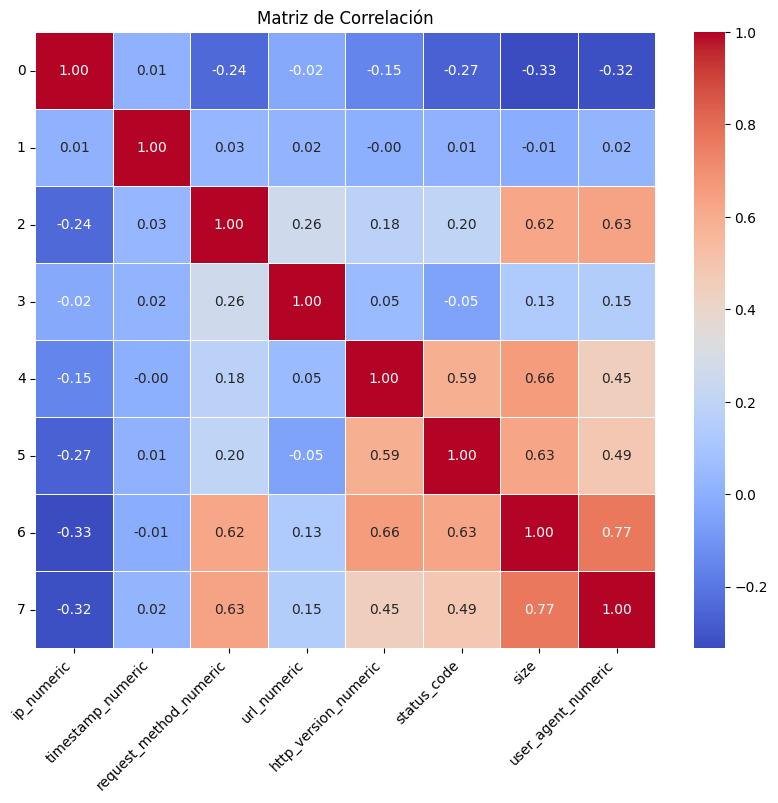

In [ ]:
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_pandas(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

plt.title('Matriz de Correlación')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
## INTENTO 2
%pip install scikit-learn

from sklearn.preprocessing import OneHotEncoder # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

df_selected = df_limpio.select([
    'request_method', 'url', 'http_version', 'status_code', 'size'
])

# Columnas categóricas y numéricas
categorical_cols = ['request_method', 'url', 'http_version']
numerical_cols = ['status_code', 'size']

# Crear y aplicar el encoder
encoder = OneHotEncoder(sparse=False)
categorical_data = encoder.fit_transform(df_selected.select(categorical_cols).to_numpy())

# Concatenar los datos numéricos y categóricos
encoded_data = np.concatenate(
    [categorical_data, df_selected.select(numerical_cols).to_numpy()], axis=1
)

# Crear el DataFrame de Polars sin especificar columnas inicialmente
df_encoded = pl.DataFrame(encoded_data)

# Asignar los nombres de las columnas
df_encoded = df_encoded.with_columns([
    pl.col(i).alias(name) for i, name in enumerate(encoder.get_feature_names_out().tolist() + numerical_cols)
])

# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Convertir a DataFrame de pandas para visualización
correlation_matrix_pandas = correlation_matrix.to_pandas()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_pandas, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


TypeError: invalid input for `col`

Expected `str` or `DataType`, got 'int'.